In [1]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import pandas as pd
import csv
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from segment_anything import sam_model_registry, SamPredictor
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

2025-05-22 14:12:54.539527: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-22 14:12:55.801140: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/asma/thermal-cnn/lib/python3.7/site-packages/cv2/../../lib64:
2025-05-22 14:12:55.801248: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/asma/thermal-cnn/lib/python3.7/site-packages/cv2/../../l

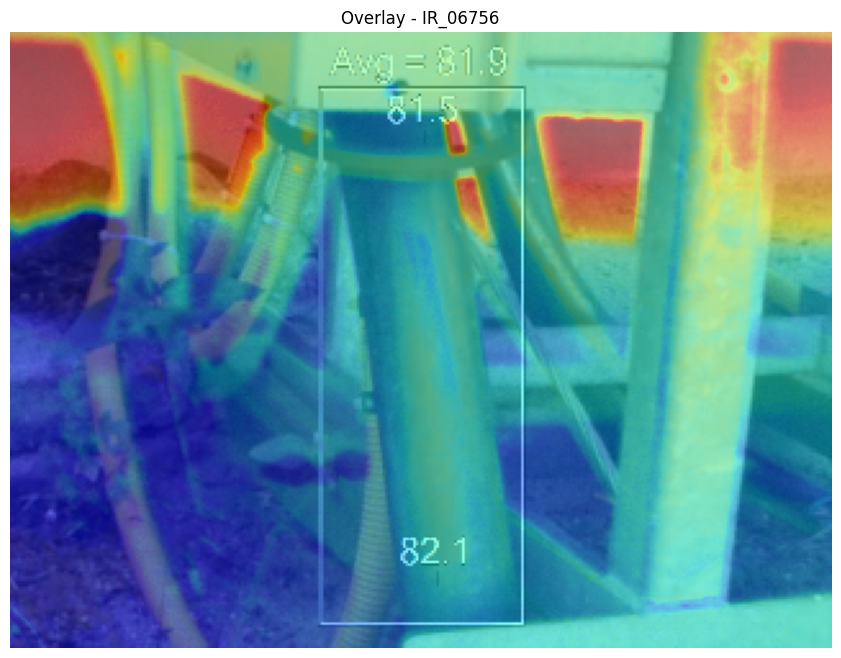

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import csv

# Paths
csv_path = './data/organized1/RMU/Cable Entry/IR_06756.csv'
img_path = './data/sample_cable_entry/IR_06756.png'

# Load thermal data
def load_smartview_csv(path):
    with open(path, 'r', encoding='utf-16', errors='ignore') as f:
        reader = csv.reader(f)
        rows = [row for row in reader if row and row[0].strip().isdigit()]
        matrix = np.array([[float(val) for val in row[1:] if val.strip()] for row in rows], dtype=np.float32)
    return matrix

thermal_matrix = load_smartview_csv(csv_path)

# Load resized image
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Overlay the thermal data
plt.figure(figsize=(12, 8))
plt.imshow(img_rgb)
plt.imshow(thermal_matrix, cmap='jet', alpha=0.5)
plt.title("Overlay - IR_06756")
plt.axis('off')
plt.show()

In [3]:

# ----------------- CONFIGURATION -----------------
BASE_PATH = './data/full_sample_resized'
SAM_CHECKPOINT = "sam_vit_b_01ec64.pth"
DEVICE = "cpu"

In [4]:
# ----------------- COMPARTMENT LABELS -----------------
compartment_labels = {
    ("VCB", "CB Close Door"): 0,
    ("VCB", "CB Open door"): 1,
    ("VCB", "3 Core Cable"): 2,
    ("VCB", "1 core cable"): 3,
    ("VCB", "Cable"): 5,
    ("VCB", "Busbar top"): 6,
    ("VCB", "Busbar side"): 7,
    ("VCB", "PT"): 10,
    ("RMU", "Cable Entry"): 4,
    ("RMU", "Fuse"): 8,
    ("RMU", "Cable"): 5,
    ("RMU", "PT"): 10
}


In [5]:
# ----------------- DATA LOADING -----------------
# Load and label images
image_paths, labels = [], []
for root, _, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith('.png'):
            full_path = os.path.join(root, file)
            folder_name = os.path.basename(root)
            parent_folder = os.path.basename(os.path.dirname(root))
            key = (parent_folder, folder_name)
            if key in compartment_labels:
                image_paths.append(full_path)
                labels.append(compartment_labels[key])

# Prepare data
X = []
for path in image_paths:
    img = cv2.imread(path)
    X.append(img / 255.0)  # No resizing, use the original 320x240 dimensions
X = np.array(X)
y = to_categorical(labels, num_classes=max(compartment_labels.values())+1)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# ----------------- MODEL TRAINING -----------------
# Build MobileNetV2 Model
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(240, 320, 3))
base_model.trainable = False
inputs = Input(shape=(240, 320, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(y.shape[1], activation='softmax')(x)
model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the Model
model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)])

2025-05-22 14:13:19.237109: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-05-22 14:13:19.237158: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tensorbook): /proc/driver/nvidia/version does not exist
2025-05-22 14:13:19.238060: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/25
9/9 [==============================] - 7s 560ms/step - loss: 2.2188 - accuracy: 0.2632 - val_loss: 1.3629 - val_accuracy: 0.6528
Epoch 2/25
9/9 [==============================] - 4s 493ms/step - loss: 1.1959 - accuracy: 0.6281 - val_loss: 0.8564 - val_accuracy: 0.8472
Epoch 3/25
9/9 [==============================] - 4s 489ms/step - loss: 0.8368 - accuracy: 0.7439 - val_loss: 0.6573 - val_accuracy: 0.8472
Epoch 4/25
9/9 [==============================] - 4s 500ms/step - loss: 0.5847 - accuracy: 0.8526 - val_loss: 0.5494 - val_accuracy: 0.8611
Epoch 5/25
9/9 [==============================] - 4s 489ms/step - loss: 0.4302 - accuracy: 0.8807 - val_loss: 0.5062 - val_accuracy: 0.8611
Epoch 6/25
9/9 [==============================] - 5s 518ms/step - loss: 0.3884 - accuracy: 0.8912 - val_loss: 0.4861 - val_accuracy: 0.8750
Epoch 7/25
9/9 [==============================] - 5s 529ms/step - loss: 0.2606 - accuracy: 0.9333 - val_loss: 0.4564 - val_accuracy: 0.8611
Epoch 8/25
9/9 [====

1/1 [==============================] - 0s 27ms/step


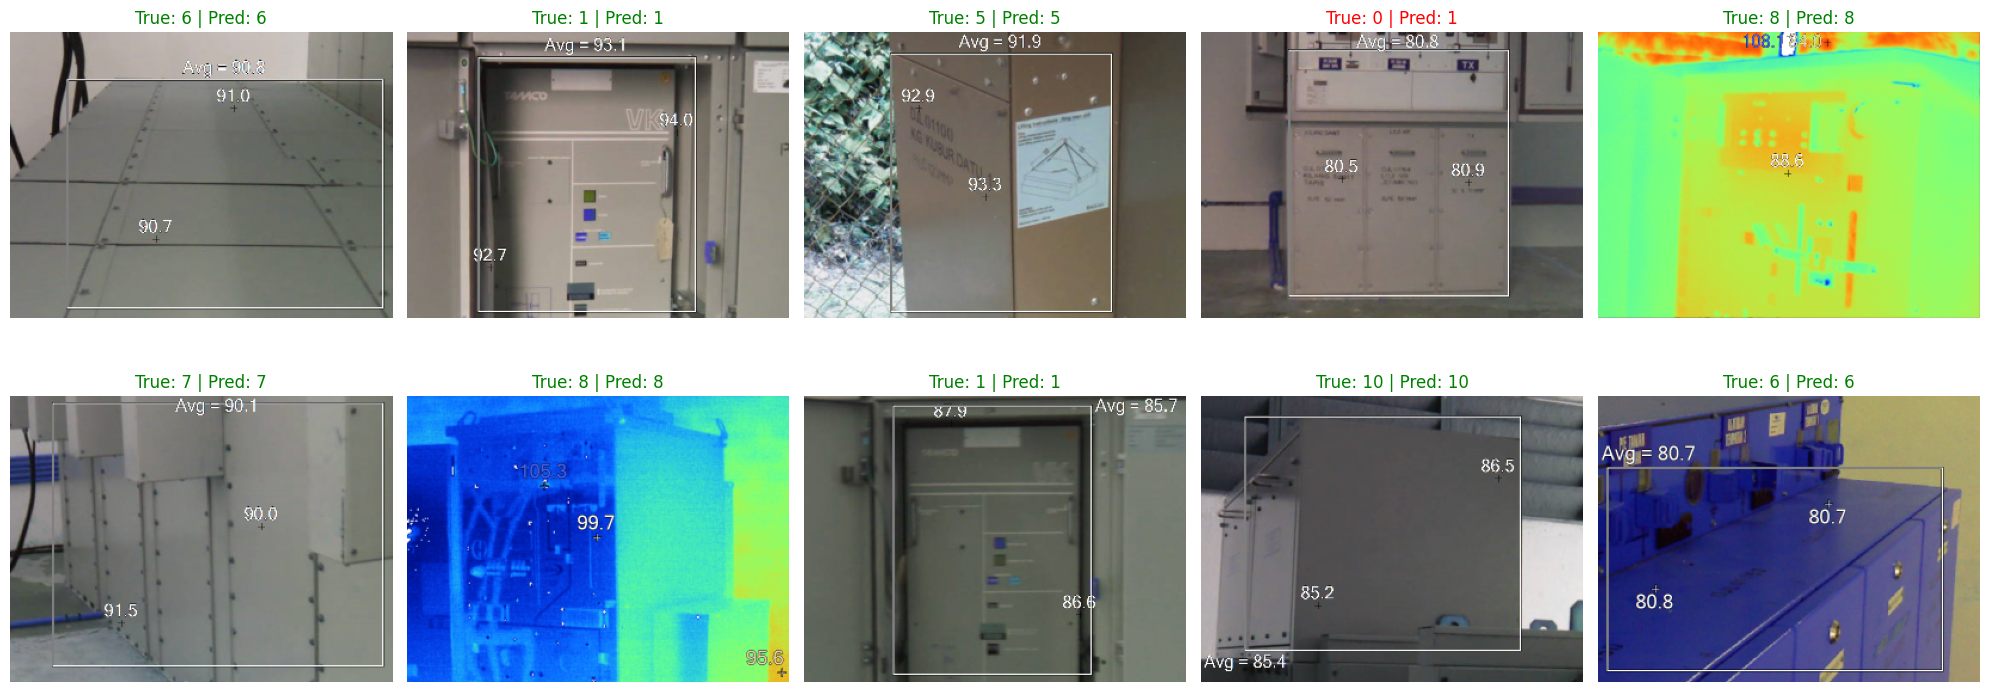

In [7]:

# ----------------- CLASSIFICATION CHECK (10 Samples) -----------------
sample_indices = random.sample(range(len(X_test)), 10)

plt.figure(figsize=(20, 8))
for i, idx in enumerate(sample_indices):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_test[idx])
    plt.axis('off')
    pred_label = np.argmax(model.predict(X_test[idx][np.newaxis]))
    true_label = np.argmax(y_test[idx])
    color = 'green' if pred_label == true_label else 'red'
    plt.title(f"True: {true_label} | Pred: {pred_label}", color=color, fontsize=12)
plt.tight_layout()
plt.show()

Selected Image: ./data/full_sample_resized/RMU/Cable Entry/IR_06838.png


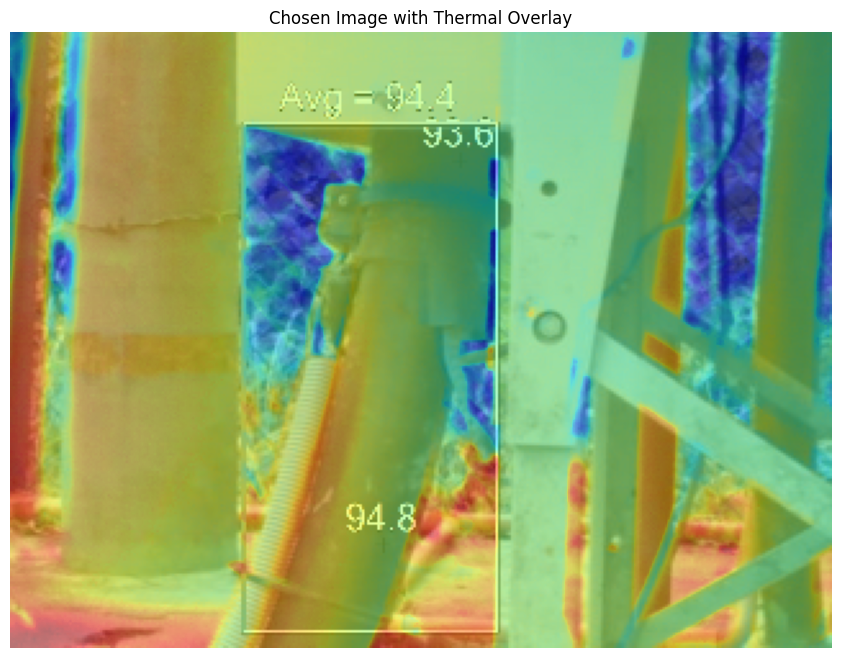

In [10]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import csv

# Configuration
TARGET_LABEL = 4  # Cable Entry
CSV_PATH = './data/organized1/RMU/Cable Entry'

# Choose a random classified image
cable_entry_images = [img for img, label in zip(image_paths, labels) if label == TARGET_LABEL]
selected_image_path = random.choice(cable_entry_images)
print(f"Selected Image: {selected_image_path}")

# Load the classified image
image = cv2.imread(selected_image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Load the corresponding thermal CSV
image_name = os.path.basename(selected_image_path).replace('.png', '.csv')
thermal_csv_path = os.path.join(CSV_PATH, image_name)

def load_smartview_csv(path):
    with open(path, 'r', encoding='utf-16', errors='ignore') as f:
        reader = csv.reader(f)
        rows = [row for row in reader if row and row[0].strip().isdigit()]
        matrix = np.array([[float(val) for val in row[1:] if val.strip()] for row in rows], dtype=np.float32)
    return matrix

thermal = load_smartview_csv(thermal_csv_path)

# Visualize the thermal overlay
plt.figure(figsize=(12, 8))
plt.imshow(image_rgb)
plt.imshow(thermal, cmap='jet', alpha=0.5)
plt.title("Chosen Image with Thermal Overlay")
plt.axis('off')
plt.show()

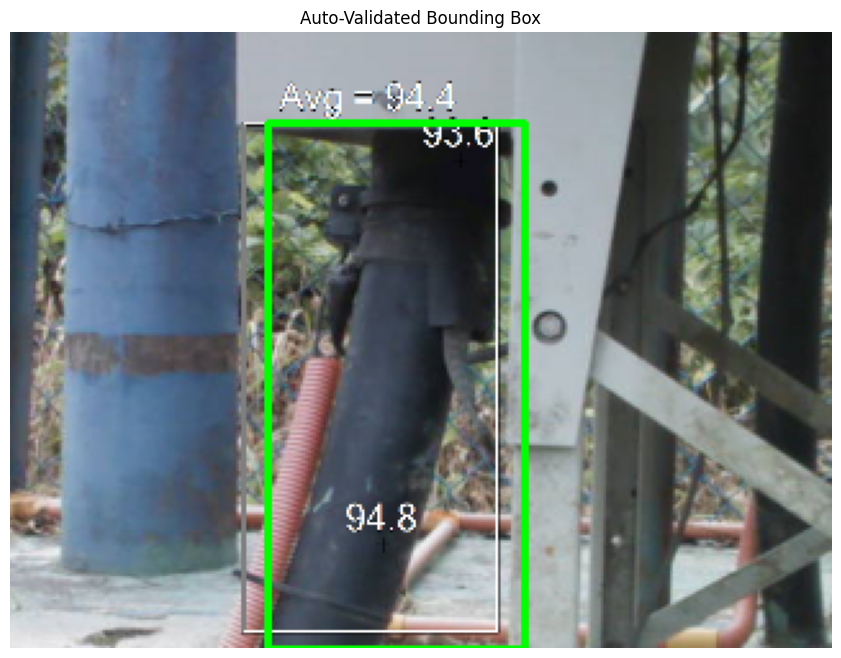

In [24]:
# ----------------- AI-AWARE AUTO-ADJUSTING BOUNDING BOX -----------------
x1, y1, x2, y2 = 100, 35, 200, 240  # Starting box
max_width = image_rgb.shape[1]
thermal_norm = cv2.normalize(thermal, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

def is_valid_segment(mask, thermal_data):
    area = np.sum(mask)
    if area < 500:
        return False
    
    # Check if thermal spread is meaningful
    temps = thermal_data[mask]
    if len(temps[temps > 0]) == 0:
        return False
    delta = np.max(temps) - np.min(temps[temps > 0])
    if delta < 5:  # too flat to be a real hotspot
        return False

    # Check mask shape
    y_indices, x_indices = np.where(mask)
    if len(x_indices) == 0 or len(y_indices) == 0:
        return False
    width = np.max(x_indices) - np.min(x_indices)
    height = np.max(y_indices) - np.min(y_indices)
    if height == 0 or width / height > 4 or height / width > 4:
        return False

    return True

valid_segment_found = False
attempts = 0
margin = 20

while not valid_segment_found and attempts < 10:
    input_box = np.array([[x1, y1, x2, y2]])
    masks, scores, _ = predictor.predict(box=input_box, multimask_output=True)
    best_mask = masks[np.argmax(scores)]

    if is_valid_segment(best_mask, thermal):
        valid_segment_found = True
    else:
        x1 = max(0, x1 - margin)
        x2 = min(max_width, x2 + margin)
        attempts += 1

# Visualize final result
img_with_box = image_rgb.copy()
cv2.rectangle(img_with_box, (x1, y1), (x2, y2), (0, 255, 0), 2)
plt.figure(figsize=(12, 8))
plt.imshow(img_with_box)
plt.title("Auto-Validated Bounding Box")
plt.axis('off')
plt.show()

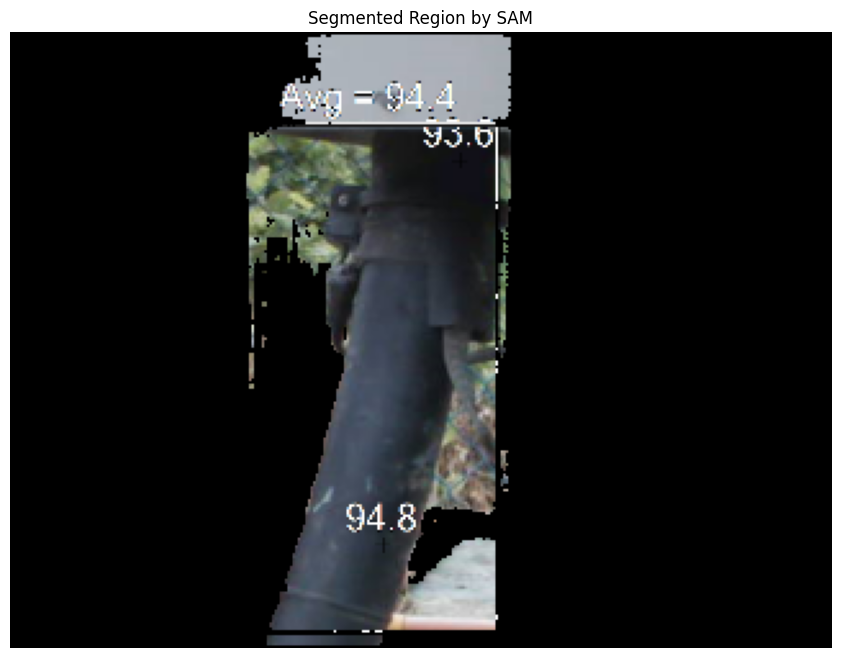

In [19]:
from segment_anything import sam_model_registry, SamPredictor
import torch

# Load SAM model
SAM_CHECKPOINT = "sam_vit_b_01ec64.pth"
DEVICE = "cpu"
sam = sam_model_registry["vit_b"](checkpoint=SAM_CHECKPOINT).to(DEVICE)
predictor = SamPredictor(sam)
predictor.set_image(image_rgb)

# Predict masks
masks, scores, logits = predictor.predict(box=input_box, multimask_output=True)
best_mask = masks[np.argmax(scores)]

# Visualize the segmented region
segmented_region = np.zeros_like(image_rgb)
segmented_region[best_mask] = image_rgb[best_mask]

plt.figure(figsize=(12, 8))
plt.imshow(segmented_region)
plt.title("Segmented Region by SAM")
plt.axis('off')
plt.show()

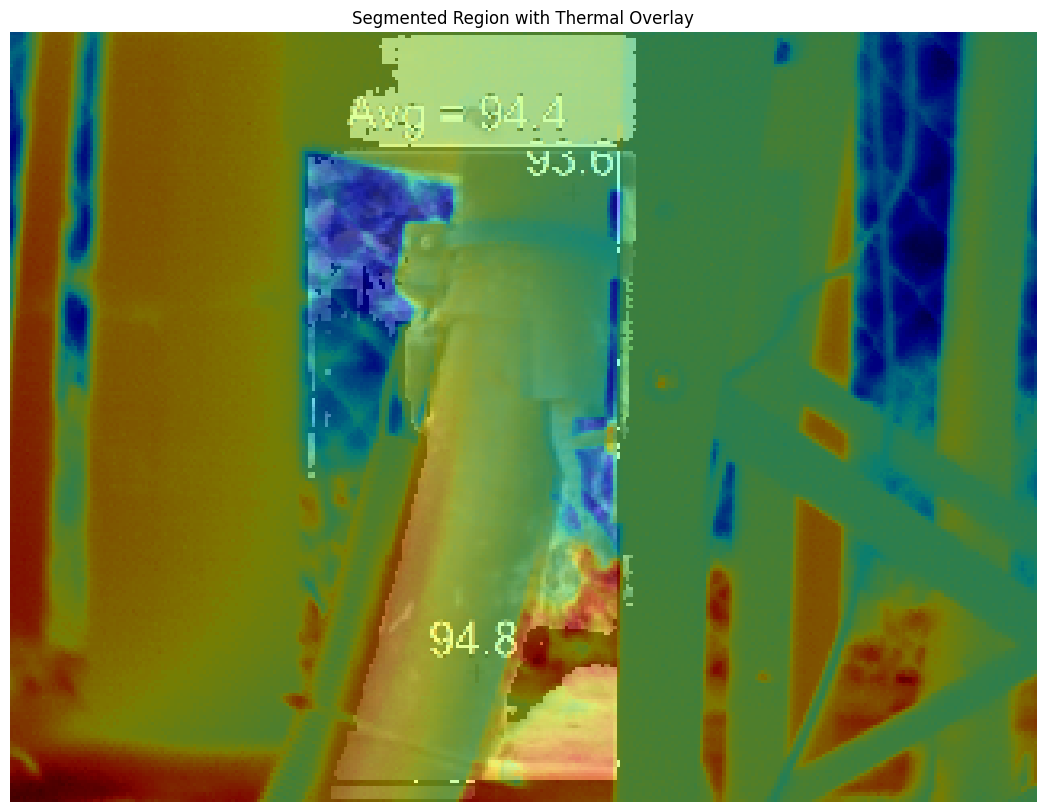

In [20]:
# Create a copy of the original image for visualization
overlay_image = image_rgb.copy()

# Apply the thermal overlay
plt.figure(figsize=(15, 10))

# Segmented region with thermal overlay
segmented_thermal_overlay = np.zeros_like(image_rgb)
segmented_thermal_overlay[best_mask] = image_rgb[best_mask]

plt.imshow(segmented_thermal_overlay)
plt.imshow(thermal, cmap='jet', alpha=0.5)
plt.title("Segmented Region with Thermal Overlay")
plt.axis('off')
plt.show()

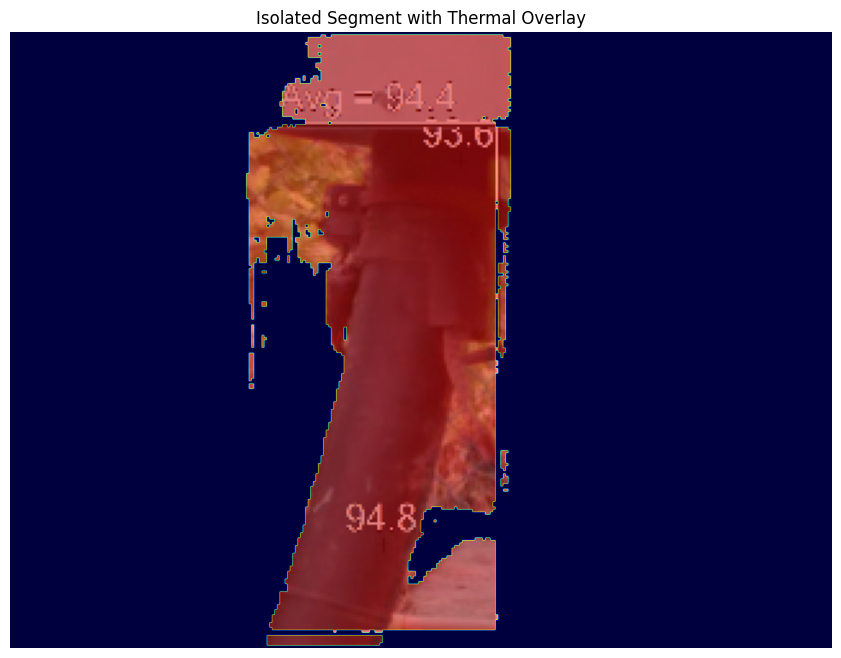

In [21]:
# Isolate only the segmented region with the thermal overlay
segmented_only = np.zeros_like(image_rgb)
thermal_masked = np.zeros_like(thermal)

# Apply the SAM mask to the thermal data
segmented_only[best_mask] = image_rgb[best_mask]
thermal_masked[best_mask] = thermal[best_mask]

# Visualize the segmented part with thermal overlay
plt.figure(figsize=(12, 8))
plt.imshow(segmented_only)
plt.imshow(thermal_masked, cmap='jet', alpha=0.5)
plt.title("Isolated Segment with Thermal Overlay")
plt.axis('off')
plt.show()

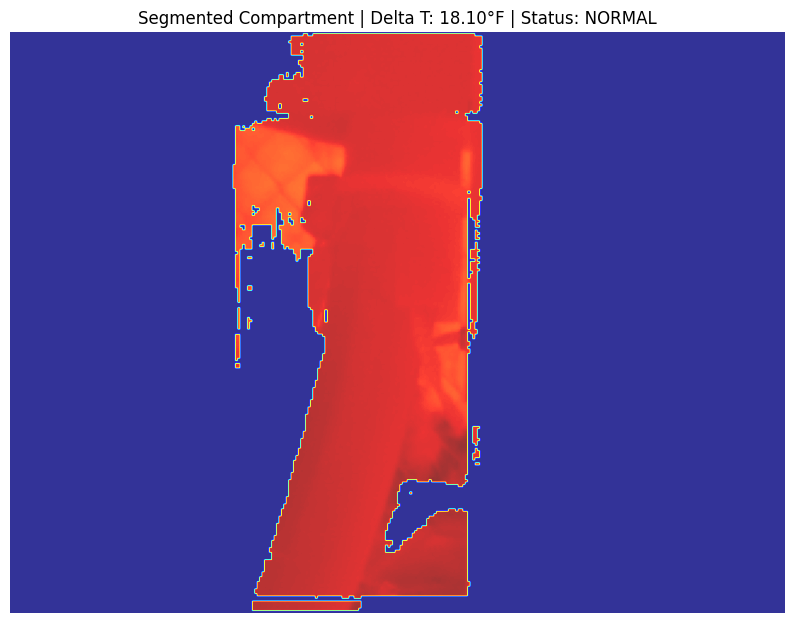

Max Temp: 102.50°F
Min Temp: 84.40°F
Delta T: 18.10°F
Status: NORMAL


In [22]:
# ----------------- DELTA T CALCULATION -----------------
# Extract the temperature values within the isolated segment
segment_temps = thermal[best_mask]

# Calculate Delta T
max_temp = np.max(segment_temps)
min_temp = np.min(segment_temps[segment_temps > 0])  # Exclude zero values (background)
delta_t = max_temp - min_temp
status = "DEFECT" if delta_t > 33.8 else "NORMAL"

# Visualize the segmented thermal region
plt.figure(figsize=(10, 8))
plt.imshow(thermal_masked, cmap='jet', alpha=0.8)
plt.title(f"Segmented Compartment | Delta T: {delta_t:.2f}°F | Status: {status}")
plt.axis('off')
plt.show()

# Print Delta T details
print(f"Max Temp: {max_temp:.2f}°F")
print(f"Min Temp: {min_temp:.2f}°F")
print(f"Delta T: {delta_t:.2f}°F")
print(f"Status: {status}")